## Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# getting data
%cd /content
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zWUzBpGEDtxTmUbNtyziheNjGs2LHQSO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zWUzBpGEDtxTmUbNtyziheNjGs2LHQSO" -O isic-data.zip && rm -rf /tmp/cookies.txt
!unzip -q isic-data.zip -d .

In [ ]:
import numpy as np
import tensorflow as tf
from importlib import reload
import sys
sys.path.append('/content/drive/My Drive/code/src')

import models_r
import isic_gen
import callbacks

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [ ]:
reload(callbacks)
reload(isic_gen)

batch_size = 20

train_size = 2000
val_size = 150

abs_train_img = './isic-challenge-2017/ISIC-2017_Training_Data'
abs_train_mask = './isic-challenge-2017/ISIC-2017_Training_GroundTruth'

abs_test_img = './isic-challenge-2017/ISIC-2017_Test_Data'
abs_test_mask = './isic-challenge-2017/ISIC-2017_Test_GroundTruth'

abs_val_img = './isic-challenge-2017/ISIC-2017_Validation_Data'
abs_val_mask = './isic-challenge-2017/ISIC-2017_Validation_GroundTruth'


train_gen = isic_gen.tf_dataset(abs_train_img, abs_train_mask, random_state = 5, batch_size = batch_size, center = True, cache = None)
val_gen = isic_gen.tf_dataset(abs_val_img, abs_val_mask, random_state = 5, batch_size = batch_size, center = True, cache = None)


  0%|          | 1/2000 [00:00<03:28,  9.60it/s]

True


100%|██████████| 2000/2000 [00:03<00:00, 535.46it/s]


In [ ]:
reload(models_r)

model1 = models_r.UNET(ch_init = 16, drp=True)
input_ = tf.zeros((1,256,256,3))
output_ = model1(input_, False)
model1.summary()

model2 = models_r.R2UNET(ch_init = 16, drp=True)
input_ = tf.zeros((1,256,256,3))
output_ = model2(input_, False)
model2.summary()

def my_custom_loss(y_true,y_pred):
    t_loss = K.max(y_pred,0)-y_pred * y_true + K.log(1+K.exp((-1)*K.abs(y_pred)))
    return K.mean(t_loss)


model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),          
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', callbacks.F1, callbacks.SE, callbacks.SP, callbacks.JS, callbacks.DC])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),          
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', callbacks.F1, callbacks.SE, callbacks.SP, callbacks.JS, callbacks.DC])

Model: "unet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block_9 (conv_block)    multiple                  2896      
_________________________________________________________________
conv_block_10 (conv_block)   multiple                  14560     
_________________________________________________________________
conv_block_11 (conv_block)   multiple                  57792     
_________________________________________________________________
conv_block_12 (conv_block)   multiple                  230272    
_________________________________________________________________
conv_block_13 (conv_block)   multiple                  919296    
_________________________________________________________________
de_conv_8 (de_conv)          multiple                  4688      
_________________________________________________________________
de_conv_9 (de_conv)          multiple                  18592

## Train

In [ ]:
# history1 = model1.fit(train_gen, steps_per_epoch = (train_size//batch_size), 
#                     epochs = 100,
#                     validation_data=val_gen, validation_steps=val_size//batch_size)
history2 = model2.fit(train_gen, steps_per_epoch = (train_size//batch_size), 
                    epochs = 20, 
                    validation_data=val_gen, validation_steps=val_size//batch_size)
pickle.dump(history2.history2, open('/content/drive/My Drive/code/r2unet_history_final_dump', 'wb'))
model2.save('/content/drive/My Drive/code/r2unet_final_isic_model')

Epoch 1/20
100/100 [==============================] - 130s 1s/step - loss: 0.5044 - accuracy: 0.8413 - F1: 0.3108 - SE: 0.2814 - SP: 0.9842 - JS: 0.2596 - DC: 0.3109 - val_loss: 0.5186 - val_accuracy: 0.8292 - val_F1: 0.4249 - val_SE: 0.5730 - val_SP: 0.9502 - val_JS: 0.3304 - val_DC: 0.4250
Epoch 2/20
100/100 [==============================] - 128s 1s/step - loss: 0.4551 - accuracy: 0.9209 - F1: 0.7350 - SE: 0.7417 - SP: 0.9778 - JS: 0.6434 - DC: 0.7351 - val_loss: 0.5107 - val_accuracy: 0.8362 - val_F1: 0.2789 - val_SE: 0.2333 - val_SP: 0.9987 - val_JS: 0.2440 - val_DC: 0.2790
Epoch 3/20
100/100 [==============================] - 128s 1s/step - loss: 0.4483 - accuracy: 0.9308 - F1: 0.7781 - SE: 0.7807 - SP: 0.9811 - JS: 0.6901 - DC: 0.7781 - val_loss: 0.5104 - val_accuracy: 0.8373 - val_F1: 0.2805 - val_SE: 0.2292 - val_SP: 0.9994 - val_JS: 0.2454 - val_DC: 0.2807
Epoch 4/20
100/100 [==============================] - 128s 1s/step - loss: 0.4462 - accuracy: 0.9337 - F1: 0.7906 - SE: 0

NameError: ignored

## Results

In [ ]:
unet_acc = history2.history['acc']
unet_val_acc = history2.history['val_acc']
r2unet_acc = history2.history['acc']
r2unet_val_acc = history2.history['val_acc']

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.ylim([0.7,1])
plt.plot(unet_acc, label='Training Accuracy, U-Net' )
plt.plot(unet_val_acc, label='Validation Accuracy, U-Net')
plt.plot(r2unet_acc, label='Training Accuracy, R2U-Net' )
plt.plot(r2unet_val_acc, label='Validation Accuracy, R2U-Net')
plt.legend(loc='lower right')
plt.show()
plt.savefig('/content/drive/My Drive/data/isicgraphs1/graph_1.png')

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


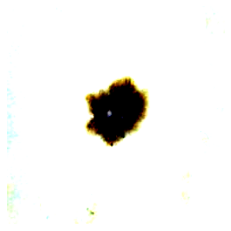

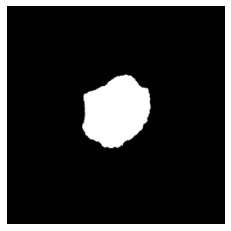

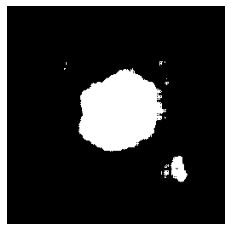

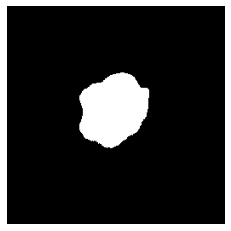

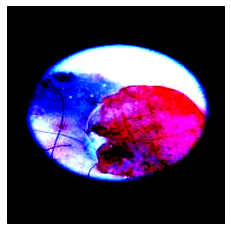

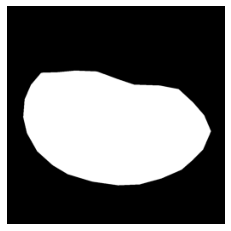

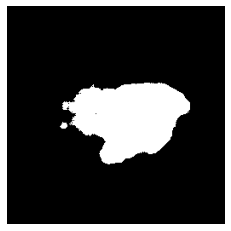

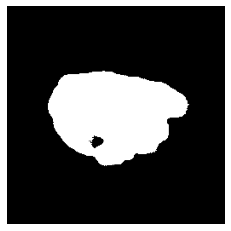

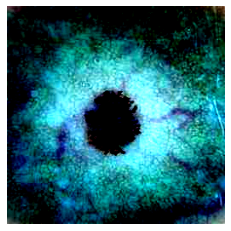

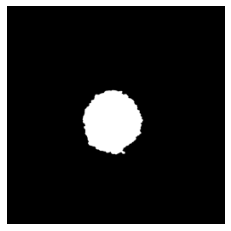

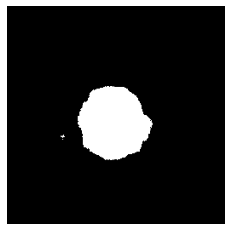

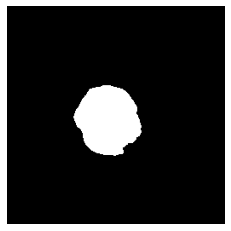

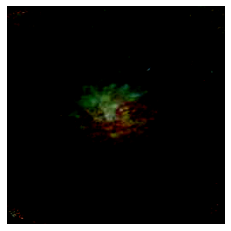

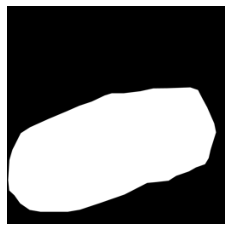

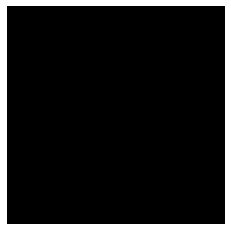

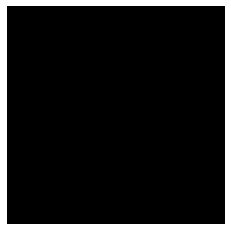

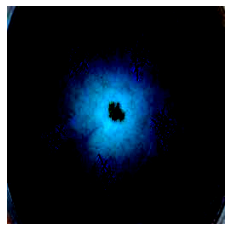

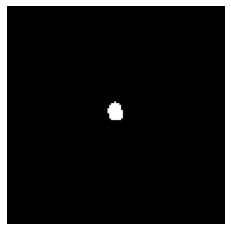

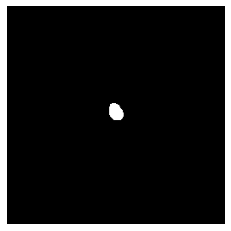

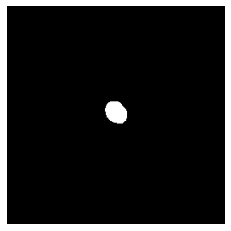

In [ ]:
import matplotlib.pyplot as plt

train_it = iter(train_gen) 
k = next(train_it)
out1 = model1.predict(k[0])
out2 = model2.predict(k[0])

def create_mask(pred_mask):
    pred_mask = tf.cast(tf.argmax(pred_mask, -1), tf.dtypes.float32)
    return pred_mask

for i in range(5):
    plt.figure()
    plt.imshow(k[0][i])
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/isicplots/orig_{i}.png')
    plt.figure()
    plt.imshow(k[1][i], cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/isicplots/ground_{i}.png')
    plt.figure()
    ok1 = create_mask(out1[i])
    plt.imshow(ok1, cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/isicplots/unet{i}.png')
    plt.figure()
    ok2 = create_mask(out2[i])
    plt.imshow(ok2, cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/isicplots/r2unet{i}.png')



In [ ]:

model_test = models_r.unet(ch_init=4)
model_test 